# Цель Блокнота

Решение задачи регрессии в scikit-learn с помощью метрической модели - к-Ближайшие соседи
* Обучение класса `KNeighborsRegressor`
* Поиск лучших гиперпараметров модели с помощью классов `RandomizedSearchCV` и `GridSearchCV`
* Сохранение модели

# Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего


# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline. Ни добавить, ни убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [ ]:
plt.style.use('dark_background') # для модных черных рисунков

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных


Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведен целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на git-hub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_no_dup_no_outliers.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

Предварительная обработка из [раннего блокнота](https://colab.research.google.com/drive/1es_OrShFiuaeOnlPjX2B1geHDM-XfofM?usp=sharing)

Из предварительной обработки исключена колонка `Price(euro)`, поскольку она является целевой меткой и будет обработана отдельно


In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [ ]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

In [ ]:
num_pipe_distance = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_distance = ['Distance']

num_pipe_engine = Pipeline([
    ('scaler', StandardScaler())
])

num_engine = ['Engine_capacity(cm3)']

num_pipe_year = Pipeline([
    ('power', PowerTransformer())
])

num_year = ['Year']

cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

cat_pipe_style_fuel = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_style_fuel = ['Style', 'Fuel_type']

cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_make = ['Make']

cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_model = ['Model']

# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
])

In [ ]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns_num = np.hstack([num_distance,
                    num_engine,
                    num_year,])

# Регрессия Методом к-Ближайших Соседей

In [ ]:
from sklearn.neighbors import KNeighborsRegressor # Регрессия К-Ближайших соседей от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

**Считываем данные, разбиваем на тестовую и тренировочную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X,y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']

# разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Оценим модель с использованием только числовых данных

**Преобразуем данные**

In [ ]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

**Обучаем модель**



Стандартная уже для нас рутина

* Создаем объект класса
* "Обучаем" через `.fit`

In [ ]:
model = KNeighborsRegressor(n_neighbors = 3,
                            weights = 'distance')

model.fit(X_train_prep, y_train);

## Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9724
r2 на валидационной выборке: 0.7001
mse на тренировочной выборке: 1676989.1684
mse на валидационной выборке: 18881951.3985


## Кросс-валидация

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [ ]:
cross_validation (X_train_prep, y_train,
                  model,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state= 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.075159,0.080331,0.697832,-1.789194e+07,-2574.931471,-30604.821996
1,0.072149,0.114810,0.694177,-1.977338e+07,-2663.497927,-36972.283630
2,0.057474,0.057106,0.672858,-2.008407e+07,-2610.604525,-40016.666667
3,0.091283,0.067784,0.695034,-1.821424e+07,-2631.002053,-27500.000000
4,0.094337,0.079752,0.678072,-1.885356e+07,-2585.080959,-42116.039382




test_R2      6.875945e-01
test_-MSE   -1.896344e+07
test_-MAE   -2.613023e+03
test_-Max   -3.544196e+04
dtype: float64


## Визуализация ошибок от scikit-learn

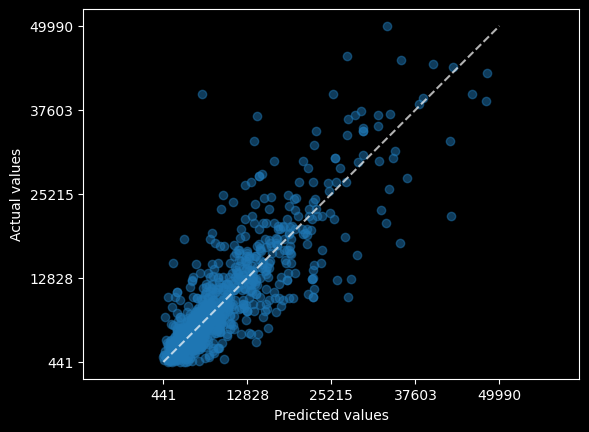

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
    line_kwargs = {"color" : 'white'}

);

## Поиск Лучших Гиперпараметров с Помощью Рандомизированного Поиска

In [ ]:
from sklearn.model_selection import RandomizedSearchCV # для поиска при случайном сэмплировании гиперпараметров
import scipy.stats as stats # статистические функции библиотеки scipy

In [ ]:
# словарь гиперпараметров в виде
# обозначение гиперпараметров : из какого распределения сэмплируем
# обозначение должно "досимвольно" совпадать с тем что в документации
parameters = {'n_neighbors':stats.randint(1,50), # задаем распределение как равномерное от 1 до 50
              'weights':['uniform', 'distance']}

# количество итераций
n_iter_search = 20

kNN_search = RandomizedSearchCV(estimator = KNeighborsRegressor(),  # оптимизируем нашу модель
                                verbose = 3,  # 3 чтобы он всё подробно расписал, если не интересно - пишем 0
                          param_distributions=parameters , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                          n_iter = n_iter_search # количество итераций
                          )

Стандартное обучение через метод `.fit()`

В этом случае он будет тестировать для выбранного `estimator` `n_iter` комбинации гиперпараметров по распределению из `param_distributions`

In [ ]:
kNN_search.fit(X_train_prep, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.734 total time=   0.2s
[CV 2/5] END ....n_neighbors=4, weights=uniform;, score=0.735 total time=   0.2s
[CV 3/5] END ....n_neighbors=4, weights=uniform;, score=0.707 total time=   0.2s
[CV 4/5] END ....n_neighbors=4, weights=uniform;, score=0.733 total time=   0.2s
[CV 5/5] END ....n_neighbors=4, weights=uniform;, score=0.716 total time=   0.1s
[CV 1/5] END ..n_neighbors=25, weights=distance;, score=0.751 total time=   0.2s
[CV 2/5] END ..n_neighbors=25, weights=distance;, score=0.742 total time=   0.2s
[CV 3/5] END ..n_neighbors=25, weights=distance;, score=0.729 total time=   0.2s
[CV 4/5] END ..n_neighbors=25, weights=distance;, score=0.746 total time=   0.1s
[CV 5/5] END ..n_neighbors=25, weights=distance;, score=0.717 total time=   0.1s
[CV 1/5] END ..n_neighbors=30, weights=distance;, score=0.751 total time=   0.1s
[CV 2/5] END ..n_neighbors=30, weights=distance

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
                   estimator=KNeighborsRegressor(), n_iter=20,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a6d8a05bf10>,
                                        'weights': ['uniform', 'distance']},
                   verbose=3)

Лучший Кандидат

In [ ]:
kNN_search.best_estimator_

KNeighborsRegressor(n_neighbors=23)

In [ ]:
kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train_prep, y_train);

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(kNNbest, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(kNNbest, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(kNNbest, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(kNNbest, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.7756
r2 на валидационной выборке: 0.7697
mse на тренировочной выборке: 13645547.2632
mse на валидационной выборке: 14501910.7609


**Рассмотрим результаты перебора**

In [ ]:
DF_reg=pd.DataFrame(kNN_search.cv_results_)
DF = DF_reg[['param_n_neighbors','param_weights',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
7,23,uniform,0.764836,0.013840,1
10,34,uniform,0.764523,0.014909,2
16,36,uniform,0.764055,0.014604,3
12,16,uniform,0.763371,0.012906,4
17,47,uniform,0.763178,0.014531,5
4,44,uniform,0.762978,0.014480,6
15,13,uniform,0.760673,0.012472,7
6,10,uniform,0.757718,0.012069,8
19,47,distance,0.740120,0.013012,9
9,39,distance,0.739401,0.012803,10


Небольшие выводы

* в сравнении с линейной регрессией в тех же условиях (только числовые признаки, целевая переменная не предобработана) модель к-ближайших соседей лучше (метрика r2 на кроссвалидации `0.76`против `0.45`)
* предпочительней тип весов `uniform`, хотя стоит отметить большую стаблильность типа весов `distance` (меньше разброс оценок)
* рост числа соседей после `13` не несет значительный вклад

* можно сказать, что в целом нет значительных ошибок как для небольших, так и для больших значений цены

# Оценим влияние предварительной обработки целевой переменной


Мы забыли поправить целевую метку - она же была не нормальная (в смысле нормального распределения)

И решение - `TransformedTargetRegressor`

In [ ]:
from sklearn.compose import TransformedTargetRegressor

In [ ]:
pipe_num_transform = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', TransformedTargetRegressor( regressor=KNeighborsRegressor(n_neighbors = 14),
    transformer=PowerTransformer())
    )
])

In [ ]:
pipe_num_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=14),
                                            transformer=PowerTransformer()))])

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.7794
r2 на валидационной выборке: 0.7599
mse на тренировочной выборке: 13417037.6836
mse на валидационной выборке: 15114743.8814


In [ ]:
cross_validation (X_train, y_train,
                  pipe_num_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state= 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.370519,0.052010,0.779605,-1.304999e+07,-2266.693583,-31224.780509
1,0.297715,0.050113,0.768636,-1.495916e+07,-2339.315625,-38799.362801
2,0.271234,0.065548,0.749713,-1.536573e+07,-2363.473503,-39916.815058
3,0.312795,0.090822,0.753744,-1.470771e+07,-2367.746447,-29238.263915
4,0.239024,0.050231,0.738782,-1.529811e+07,-2324.323162,-44605.099207




test_R2      7.580961e-01
test_-MSE   -1.467614e+07
test_-MAE   -2.332310e+03
test_-Max   -3.675686e+04
dtype: float64


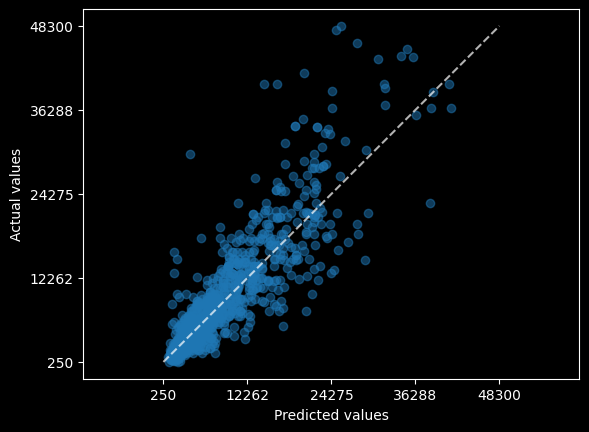

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_num_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
    line_kwargs = {"color" : 'white'}

);

## Поиск Лучших Гиперпараметров по Сетке Параметров

In [ ]:
from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров

from sklearn.metrics import make_scorer #функция для создания объекта из метрики для использования в кросс-валидации

In [ ]:
pipe_num_transform

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=14),
                                            transformer=PowerTransformer()))])

In [ ]:
param_grid = {
    # ВАЖНО: используем "имена", которые есть у компонент Pipeline и разделяем их __ (две земли)
    "preprocessors__num_distance__QuantReplace__threshold": [0, 0.01],
    "model__regressor__n_neighbors": np.arange(1,50,8),
    "model__regressor__weights": ['uniform', 'distance'],
}

In [ ]:
scorer = make_scorer(r2_score)

In [ ]:
Pipe_GS = GridSearchCV(estimator = pipe_num_transform, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                       cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       scoring = scorer, # указываем метрику которую оптимизируем
                       verbose = 3 # 3 чтобы он всё подробно расписал, если не интересно - пишем 0
                       )
Pipe_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num_distance',
                                                                         Pipeline(steps=[('QuantReplace',
                                                                                          QuantileReplacer(threshold=0.01)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Distance']),
                                                                        ('num_engine',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         [...
                                                                         ['Year'])])),
                                       ('model',
                                        TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=14),
                                                                   transformer=PowerTransformer()))]),
             param_grid={'model__regressor__n_neighbors': array([ 1,  9, 17, 25, 33, 41, 49]),
                         'model__regressor__weights': ['uniform', 'distance'],
                         'preprocessors__num_distance__QuantReplace__threshold': [0,
                                                                                  0.01]},
             scoring=make_scorer(r2_score), verbose=3)

Стандартное обучение через метод `.fit()`

В этом случае он будет тестировать для выбранного `estimator` все перечисленные комбинации гиперпараметров / аргументов из `param_grid`

In [ ]:
Pipe_GS.fit(X_train, y_train);

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_distance__QuantReplace__threshold=0;, score=0.611 total time=   0.3s
[CV 2/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_distance__QuantReplace__threshold=0;, score=0.613 total time=   0.2s
[CV 3/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_distance__QuantReplace__threshold=0;, score=0.576 total time=   0.2s
[CV 4/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_distance__QuantReplace__threshold=0;, score=0.597 total time=   0.2s
[CV 5/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_distance__QuantReplace__threshold=0;, score=0.607 total time=   0.2s
[CV 1/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessor

Лучший Кандидат

In [ ]:
Pipe_best=Pipe_GS.best_estimator_
Pipe_best

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=25),
                                            transformer=PowerTransformer()))])

In [ ]:
Pipe_best.fit(X_train, y_train);

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.7672
r2 на валидационной выборке: 0.7631
mse на тренировочной выборке: 14157818.3589
mse на валидационной выборке: 14914681.2051


### Проанализируем результат

На уровне гиперпараметров

In [ ]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_Pipe.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__regressor__n_neighbors',
       'param_model__regressor__weights',
       'param_preprocessors__num_distance__QuantReplace__threshold', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [ ]:
DF_ = DF_Pipe[[ # берем только гиперпараметры,
       'param_model__regressor__n_neighbors',
       'param_model__regressor__weights',
       'param_preprocessors__num_distance__QuantReplace__threshold',
                 'mean_test_score', #среднее значение метрики на кросс-валидации
             'std_test_score', # разброс метрики на кросс-валидации
             'rank_test_score',# место
             ]]
cm = sns.light_palette("orange", as_cmap=True) # делаем расцветку по значению. В этот раз "50 оттенков Оранжевого"
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) # сортируем по убыванию места и раскрашиваем
hl

,param_model__regressor__n_neighbors,param_model__regressor__weights,param_preprocessors__num_distance__QuantReplace__threshold,mean_test_score,std_test_score,rank_test_score
13,25,uniform,0.010000,0.760078,0.015050,1
16,33,uniform,0,0.760030,0.015911,2
17,33,uniform,0.010000,0.759678,0.015811,3
12,25,uniform,0,0.759609,0.015677,4
9,17,uniform,0.010000,0.759380,0.015036,5
20,41,uniform,0,0.758431,0.015990,6
8,17,uniform,0,0.758422,0.015162,7
21,41,uniform,0.010000,0.757695,0.015424,8
24,49,uniform,0,0.757580,0.016194,9
25,49,uniform,0.010000,0.756609,0.015702,10


Небольшие выводы:

* Предварительная обработка целевой переменной не так полезна, как для линейной модели ( метрики r2 на кроссвалидации осталась `0.76` , против роста с `0.49` до `0.56`)

* предпочительней тип весов `uniform`, при этом стоит отметить разброс для типа весов `distance` не сильно меньше (по сравнению с ситуацией, когда мы не обрабатывали целевую переменную)

* рост числа соседей после `17` не несет значительный вклад

* в предварительной обработке не принципиально удалять редкие значения признаков или нет



# Про то как, Сохранять Модель

In [ ]:
from joblib import dump, load # в scikit-learn ничего такого особенного нет
# пользуемся joblib

In [ ]:
dump(model, 'model.joblib')  # чтобы сохранить объект
dump(kNNbest, 'best_knn.joblib')  # чтобы сохранить объект
dump(Pipe_best, 'Pipe_best_knn.joblib')  # чтобы сохранить объект

['Pipe_best_knn.joblib']